In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13672164432748352857
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6714144194
locality {
  bus_id: 1
  links {
  }
}
incarnation: 736464816926312285
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


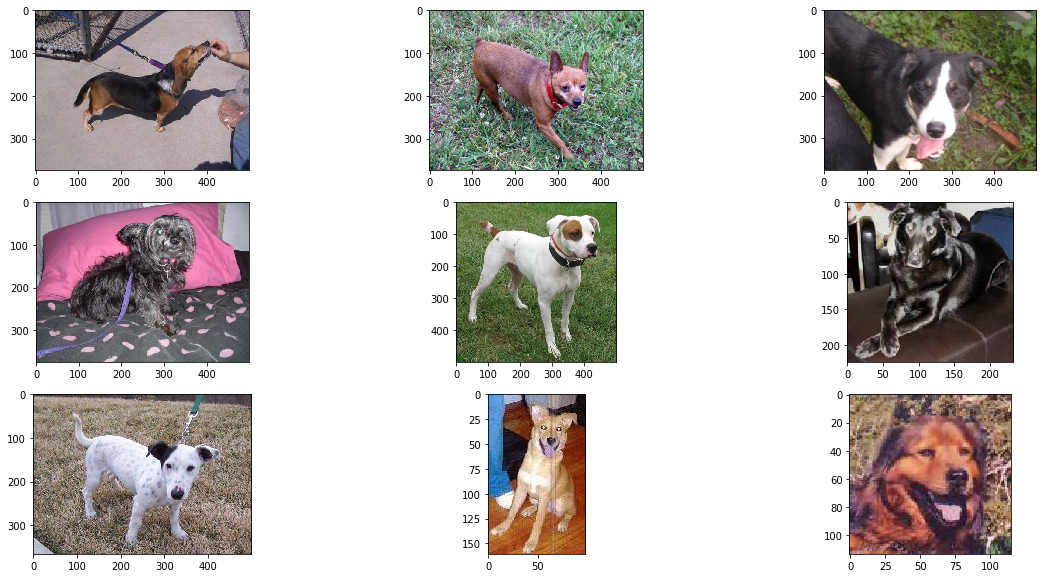

In [19]:
# plot image
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
# define location of dataset
folder = 'dogs-vs-cats/train/dog/'
plt.figure(figsize=(20,10))
# plot first few images
for i in range(9):
    # 3x3 subpot
    plt.subplot(3,3,1+i)
    # select one image from dataset at random
    filename = folder + 'dog.' + str(np.random.randint(1000)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

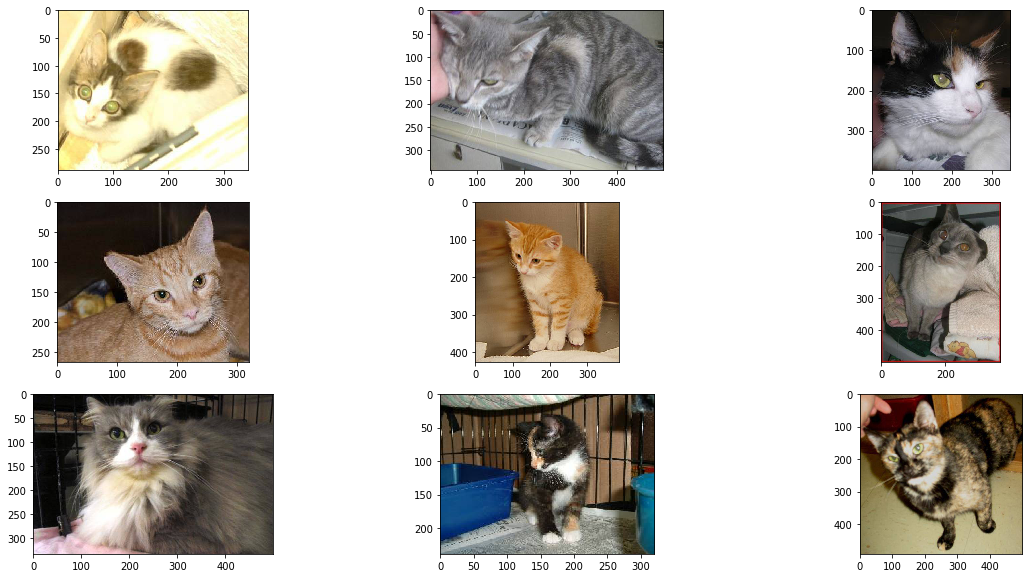

In [3]:
folder = 'dogs-vs-cats/train/cat/'
plt.figure(figsize=(20,10))
for i in range(9):
	plt.subplot(3, 3, 1+i)
	filename = folder + 'cat.' + str(np.random.randint(1000)) + '.jpg'
	image = imread(filename)
	plt.imshow(image)
plt.show()

In [4]:
from keras.preprocessing.image import ImageDataGenerator
resize = 224
train_dir = 'dogs-vs-cats/train/'
val_dir = 'dogs-vs-cats/validation/'
train_pic_gen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest')
                                  )
val_pic_gen = ImageDataGenerator(rescale=1./255)
train_flow = train_pic_gen.flow_from_directory(train_dir,
                                               target_size=(resize,resize),
                                               batch_size=32,
                                               class_mode='binary')
val_flow = val_pic_gen.flow_from_directory(val_dir,
                                             target_size=(resize,resize),
                                             batch_size=32,
                                             class_mode='binary')
print(train_flow.class_indices)

Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}


In [5]:
import pandas as pd
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D, Conv2D
from keras import callbacks
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.optimizers import SGD

In [6]:
def VGG_16():
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(resize, resize, 3), padding='same', activation='relu', name='conv1_block'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',name='conv2_block'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',name='conv3_block'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',name='conv4_block'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',name='conv5_block'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',name='conv6_block'))
    model.add(Conv2D(256, (1, 1), activation='relu', padding='same',name='conv7_block'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',name='conv8_block'))
    #model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',name='conv9_block'))
    model.add(Conv2D(512, (1, 1), activation='relu', padding='same',name='conv10_block'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',name='conv11_block'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',name='conv12_block'))
    model.add(Conv2D(512, (1, 1), activation='relu', padding='same',name='conv13_block'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
 
    return model


In [7]:
model = VGG_16()
sgd = SGD(lr=0.001, decay=1e-8, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['binary_crossentropy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_block (Conv2D)         (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2_block (Conv2D)         (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv3_block (Conv2D)         (None, 112, 112, 128)     73856     
_________________________________________________________________
conv4_block (Conv2D)         (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     512       
__________

In [8]:
from datetime import datetime
logdir="logs/vggfit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
CallBack = callbacks.TensorBoard(log_dir = logdir, 
                                 histogram_freq= 0,
                                 write_graph=True,
                                 write_images=True)

In [9]:
his = model.fit_generator(train_flow,
                        steps_per_epoch=100,
                        epochs=50,
                        verbose=1,
                        validation_data=val_flow,
                        validation_steps=50,
                        shuffle=True,
                        callbacks=[CallBack])

Epoch 1/50
100/100 [==============================] - 71s 714ms/step - loss: 0.9959 - binary_crossentropy: 0.9959 - val_loss: 0.9261 - val_binary_crossentropy: 0.9261
Epoch 2/50
100/100 [==============================] - 64s 643ms/step - loss: 0.8476 - binary_crossentropy: 0.8476 - val_loss: 0.6685 - val_binary_crossentropy: 0.6685
Epoch 3/50
100/100 [==============================] - 63s 634ms/step - loss: 0.7735 - binary_crossentropy: 0.7735 - val_loss: 0.6426 - val_binary_crossentropy: 0.6426
Epoch 4/50
100/100 [==============================] - 52s 520ms/step - loss: 0.6875 - binary_crossentropy: 0.6875 - val_loss: 0.6142 - val_binary_crossentropy: 0.6142
Epoch 5/50
100/100 [==============================] - 53s 526ms/step - loss: 0.6658 - binary_crossentropy: 0.6658 - val_loss: 0.6315 - val_binary_crossentropy: 0.6315
Epoch 6/50
100/100 [==============================] - 53s 530ms/step - loss: 0.6400 - binary_crossentropy: 0.6400 - val_loss: 0.6665 - val_binary_crossentropy: 0.666

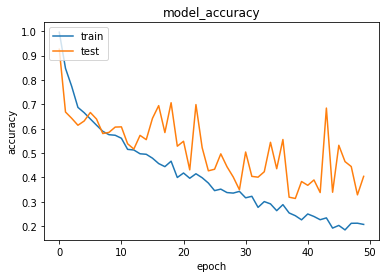

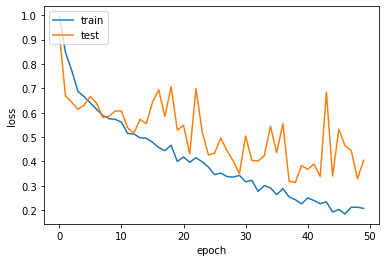

In [13]:
plt.plot(his.history['binary_crossentropy'])
plt.plot(his.history['val_binary_crossentropy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
model.save('./weights/vgg_catdogs_model.h5')

dog


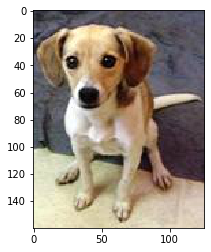

In [18]:
import cv2
model.load_weights('./weights/vgg_catdogs_model.h5')
folder = 'dogs-vs-cats/test/test1/'
filename = folder + str(np.random.randint(1000)) + '.jpg'
test_image = cv2.resize(cv2.imread(filename),(resize,resize))
test_image = np.asarray(test_image.astype("float32"))
test_image = test_image/255.
test_image = test_image.reshape((1,resize,resize,3))
preds = model.predict(test_image)
if preds <= 0.5:
    print("cat")
else:
    print("dog")
image = imread(filename)
plt.imshow(image)
#plt.show()